In [56]:
import os, sys
import time
# set the working directory
sys.path.append(os.getcwd()+ os.sep + ".." + os.sep + "..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycaret.classification as pc
import seaborn as sns
from imblearn.over_sampling import SMOTE, SMOTEN, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# import from ../script/data.py in scripts folder
from src.scripts.data import CR8_smoke_dict, OR45_dict 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [57]:
greece_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:5, 9:6}
poland_dict = {1:1, 2:1, 3:2, 4:3, 5:4, 6:4, 7:4, 8:5, 9:6}
romania_dict = {1:1, 2:2, 3:3, 4:4, 5:4, 6:4, 7:4, 8:5, 9:5, 10:6}
england_dict = {"No Qualification": 1, "GCSE/O Level": 2, "GCSE/CSE": 3, "A Levels": 4, "ONC/BTEC": 4, "Other/Sub Degree": 4, "Higher/Sub Degree": 5, "Degree": 5}

def read_dataframes(folder_path):
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.sas7bdat')]
    print(file_list)
    dataframes = {file: pd.read_sas(os.path.join(folder_path, file)) for file in file_list}
    return dataframes


def get_common_columns(dataframes):
    # rename all columns to lower case
    for df in dataframes.values():
        df.columns = df.columns.str.upper()
    
    common_columns = dataframes[list(dataframes.keys())[0]].columns
    for df in dataframes.values():
        common_columns = common_columns.intersection(df.columns)
    return common_columns


def preprocess_dataframes(dataframes, common_columns):
    merged_df = pd.DataFrame()
    for i, (file, df) in enumerate(dataframes.items()):
        df = df[common_columns]
        # df.insert(0, "State", file.split(" ")[2])
        
        state = file.split(" ")[2].split(".")[0]
        if state == "Greece":
            df["A04"] = df["A04"].map(greece_dict)
        elif state == "Poland":
            df["A04"] = df["A04"].map(poland_dict)
        elif state == "Romania":
            df["A04"] = df["A04"].map(romania_dict)
        
        df.insert(0, "State", i)
        merged_df = pd.concat([merged_df, df])
        
    merged_df.rename(columns={"AGE": "Age"}, inplace=True)
    merged_df.rename(columns={"A01": "Gender"}, inplace=True)
    merged_df.rename(columns={"B01": "Smoke"}, inplace=True)
    merged_df["Smoke"] = merged_df["Smoke"].map({1: True, 2: True, 3: False})
    merged_df.rename(columns={"A04": "Education"}, inplace=True)    
    merged_df.rename(columns={"A11": "MaritalStatus"}, inplace=True) 

    england_df = pd.read_csv("../../data/raw/smoking_england.csv")
    england_df.insert(0, "State", i+1)
    
    # rename all column of england_df to Title Case
    england_df.columns = england_df.columns.str.title()
    
    england_df["Smoke"] = england_df["Smoke"].map({"Yes": True, "No": False})
    england_df["Education"] = england_df["Highest_Qualification"].map(england_dict)
    england_df["Gender"] = england_df["Gender"].map({"Male":1, "Female":2})
    england_df["MaritalStatus"] = england_df["Marital_Status"].map({"Single": 1, "Married": 2, "Separated":3, "Divorced": 4, "Widowed": 5})
    merged_df = pd.concat([merged_df, england_df])

    return merged_df


Data preprocessing

In [72]:
# open sas7bdat file
# file = pd.read_sas('../../data/raw/GATS/GATS_Greece_National_2013_SAS/GREECE_PUBLIC_USE_11Mar2015.sas7bdat')

# Read dataframes from GYTS folder
dataframes = read_dataframes("../../data/raw/GATS/")

for df in dataframes.values():
    if "A11" not in df.columns:
        df["A11"] = None

# Find common columns in all dataframes
common_columns = get_common_columns(dataframes)

# Preprocess dataframes
merged_df = preprocess_dataframes(dataframes, common_columns)

# count number of A11 values
# print(merged_df["MaritalStatus"].value_counts())

# Drop rows with missing values
# merged_df = merged_df.dropna()

['GATS 2018 Romania.sas7bdat', 'GATS 2011 Poland.sas7bdat', 'GATS 2015 Greece.sas7bdat']


In [77]:

merged_df = merged_df[['State', 'Age', 'Gender', 'Smoke', 'Education', 'MaritalStatus']]

merged_df = merged_df.dropna()

#use IterativeImputer to fill missing values of Education and MaritalStatus
#imp = IterativeImputer(max_iter=10, random_state=0)
#merged_df = pd.DataFrame(imp.fit_transform(merged_df), columns=merged_df.columns)


merged_df["State"] = merged_df["State"].astype('int').astype('category')
merged_df['Age'] = merged_df['Age'].astype('int')
merged_df['Gender'] = merged_df['Gender'].astype('int').astype('category')
merged_df["Education"] = merged_df["Education"].astype('category')
merged_df["MaritalStatus"] = merged_df["MaritalStatus"].astype('category')
merged_df["Smoke"] = merged_df["Smoke"].astype('bool')



# print the number of missing values in each column
print(merged_df.isnull().sum())

merged_df.tail()

# 1 no formal education
# 2 primary education
# 3 secondary school
# 4 high school
# 5 university
# 6 postgraduate

State            0
Age              0
Gender           0
Smoke            0
Education        0
MaritalStatus    0
dtype: int64


,State,Age,Gender,Smoke,Education,MaritalStatus
1686,3,22,1,False,1.0,1.0
1687,3,49,2,True,4.0,4.0
1688,3,45,1,False,4.0,2.0
1689,3,51,2,True,1.0,2.0
1690,3,31,1,False,5.0,2.0


In [78]:
# Split the data into train and test sets
train, test = train_test_split(merged_df, test_size=0.2, random_state=42)
test.reset_index(drop=True, inplace=True)

# Split the train set into features and target
X = train.drop(columns=["Smoke"])
y = train["Smoke"]

# Convert y values to categorical values
lab = preprocessing.LabelEncoder()
y = lab.fit_transform(y)

No Sampling

In [79]:
y = pd.DataFrame(y, columns=["Smoke"])
y.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)
train = pd.concat([X, y] , axis=1)

+ Oversampling

In [80]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert array to dataframe
y_resampled = pd.DataFrame(y_resampled, columns=['Smoke'])
# y = pd.DataFrame(y, columns=['Smoke'])

# remove index
# X.reset_index(drop=True, inplace=True)
# y.reset_index(drop=True, inplace=True)
X_resampled.reset_index(drop=True, inplace=True)

train = pd.concat([X_resampled, y_resampled], axis=1)
# df_resampled = pd.concat([X, y], axis=1)

Comparing models

In [81]:
setup = pc.setup(data=train,
                target='Smoke',
                session_id=123,
                normalize=True,
                transformation=True,
                remove_multicollinearity=True, multicollinearity_threshold=0.95, max_encoding_ohe=0,
                # fix_imbalance=True, fix_imbalance_method=SMOTE(),
                imputation_type='iterative',
                categorical_features=['State', 'Gender', 'Education', 'MaritalStatus'],
                numeric_features=['Age']
                )

pc.compare_models()

,Description,Value
0,Session id,123
1,Target,Smoke
2,Target type,Binary
3,Original data shape,"(6342, 6)"
4,Transformed data shape,"(6342, 6)"
5,Transformed train set shape,"(4439, 6)"
6,Transformed test set shape,"(1903, 6)"
7,Numeric features,1
8,Categorical features,4
9,Rows with missing values,11.1%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7373,0.5000,0.7676,0.7246,0.7452,0.4747,0.4759,0.1430
lightgbm,Light Gradient Boosting Machine,0.7335,0.5000,0.7689,0.7190,0.7429,0.4670,0.4684,0.3920
gbc,Gradient Boosting Classifier,0.7326,0.5000,0.7662,0.7193,0.7415,0.4652,0.4668,0.0320
xgboost,Extreme Gradient Boosting,0.7310,0.5000,0.7721,0.7147,0.7418,0.4621,0.4641,0.0220
ada,Ada Boost Classifier,0.7171,0.5000,0.7140,0.7199,0.7164,0.4341,0.4348,0.0220
rf,Random Forest Classifier,0.7128,0.5000,0.7437,0.7022,0.7217,0.4256,0.4270,0.0490
et,Extra Trees Classifier,0.7128,0.5000,0.7185,0.7114,0.7145,0.4256,0.4261,0.0430
dt,Decision Tree Classifier,0.7076,0.5000,0.7090,0.7083,0.7082,0.4152,0.4158,0.0170
knn,K Neighbors Classifier,0.7060,0.5000,0.7333,0.6964,0.7138,0.4120,0.4134,0.0180
qda,Quadratic Discriminant Analysis,0.6900,0.5000,0.7703,0.6639,0.7130,0.3800,0.3854,0.0140


Choosing best model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.5000,0.7613,0.7445,0.7528,0.5000,0.5001
1,0.7320,0.5000,0.8243,0.6958,0.7546,0.4640,0.4721
2,0.7432,0.5000,0.7613,0.7348,0.7478,0.4865,0.4868
3,0.6869,0.5000,0.7613,0.6627,0.7086,0.3739,0.3781
4,0.7342,0.5000,0.7523,0.7261,0.7389,0.4685,0.4688
5,0.6959,0.5000,0.7432,0.6790,0.7097,0.3919,0.3937
6,0.7635,0.5000,0.7883,0.7511,0.7692,0.5270,0.5277
7,0.7432,0.5000,0.7568,0.7368,0.7467,0.4865,0.4867
8,0.7162,0.5000,0.7432,0.7051,0.7237,0.4324,0.4331


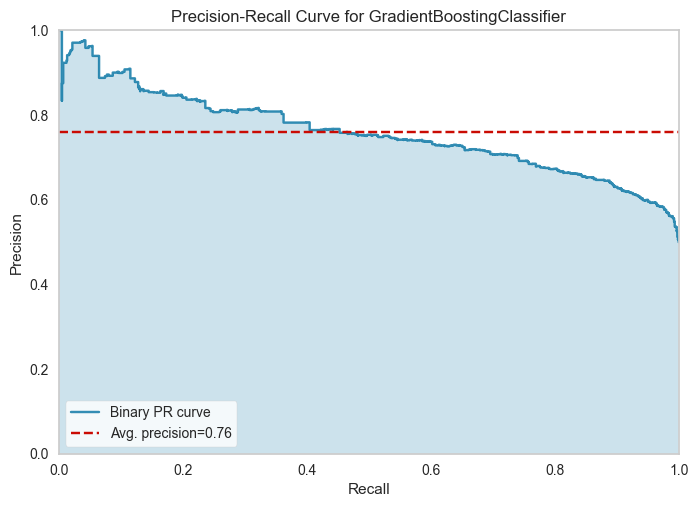

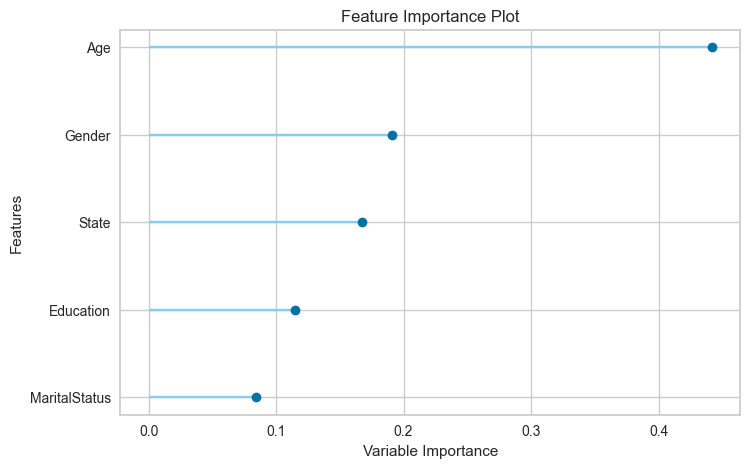

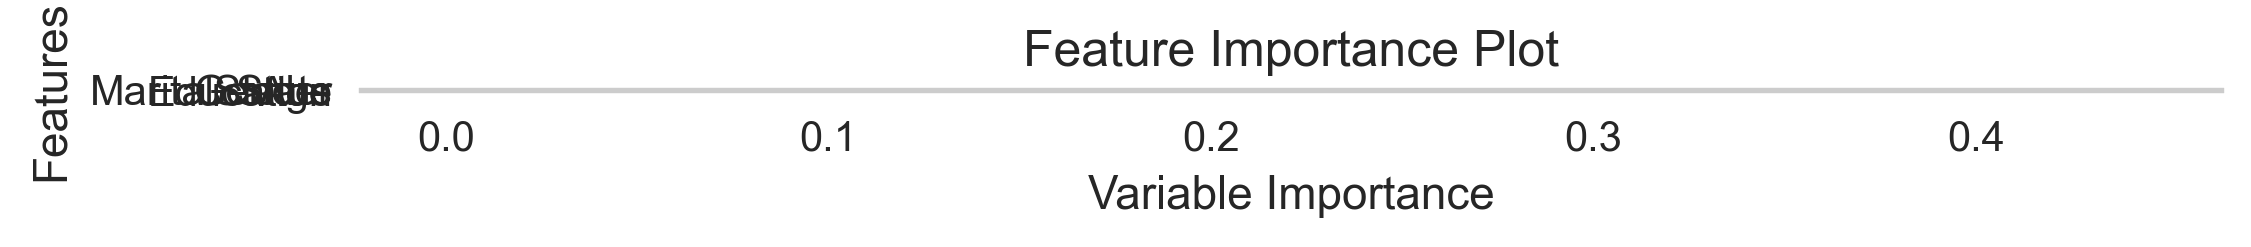

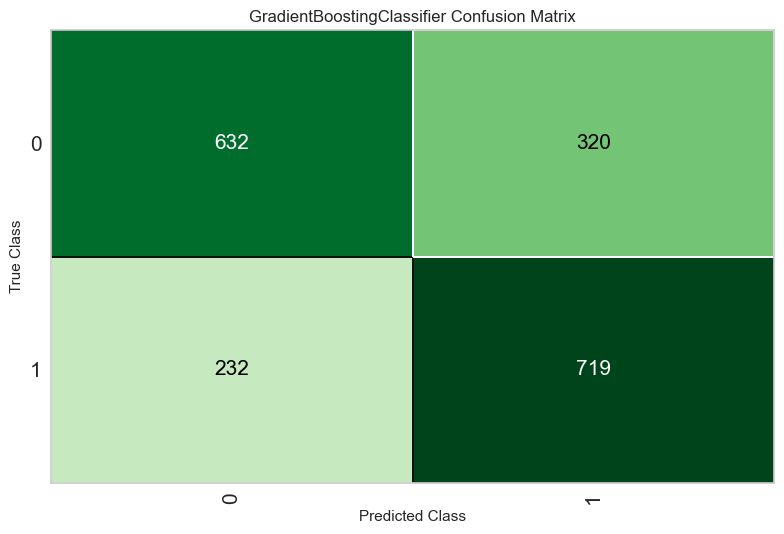

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7215,0.7958,0.7645,0.7038,0.7329,0.4430,0.4447


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6917,0.7526,0.6413,0.5488,0.5915,0.3463,0.3491


  State  Age Gender Education MaritalStatus  Smoke  prediction_label  \
0     2   33      1       5.0           2.0  False                 1   
1     2   73      1       2.0           2.0  False                 0   
2     3   34      2       5.0           2.0  False                 0   
3     3   58      2       5.0           2.0  False                 0   
4     2   73      1       1.0           2.0  False                 1   

   prediction_score  
0            0.7547  
1            0.7441  
2            0.7680  
3            0.8681  
4            0.5470  


In [82]:
# Extra Trees Classifier
model = pc.create_model('catboost')


# pc.plot_model(model, plot='auc')
pc.plot_model(model, plot='pr')
pc.plot_model(model, plot='feature')
pc.plot_model(model, plot='feature_all',scale=3)
pc.plot_model(model, plot='confusion_matrix')

final_rf = pc.finalize_model(model)
# final_rf
pc.predict_model(final_rf)
# print(final_rf)

unseen_predictions = pc.predict_model(final_rf, data=test)
print(unseen_predictions.head())

In [83]:
# model = ExtraTreesClassifier(model)

pd.DataFrame({'Feature': pc.get_config('X_train').columns, 'Value' : abs(model.feature_importances_)}).sort_values(by='Value', ascending=False)

,Feature,Value
1,Age,0.442124
2,Gender,0.191056
0,State,0.167667
3,Education,0.114587
4,MaritalStatus,0.084566


In [85]:
pc.interpret_model(model, plot='summary')

TypeError: This function only supports tree based models for binary classification: xgboost, dt, lightgbm, et, catboost, rf.